In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt

## Histogramas

Un histograma es una visualizacion de datos donde se definen "contenedores" (rangos de valores) para una variable, y se cuenta la canitdad de puntos de datos dentro de cada contenedor.

De esta forma, podemos visualizar la distribucion de la variable.

*Ejemplo:*

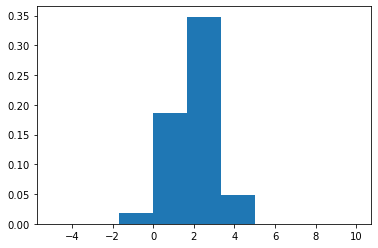

In [2]:
np.random.seed(1)
xs = np.random.normal(2, 1, 100).reshape(-1, 1)  # Obtengo 100 valores dados con una distribucion normal de media: 2 y desvio estandar: 1

def plot_histogram(xs, x_range, n_containers, axes=plt):
    interval_containers = np.linspace(x_range[0], x_range[1], n_containers)
    return axes.hist(xs, interval_containers, density=True)

plot_histogram(xs, (-5, 10), 10)
plt.show()

Esta forma de visualizar los datos tiene un problema: el grafico obtenido varia mucho según la cantidad de contenedores elegida.

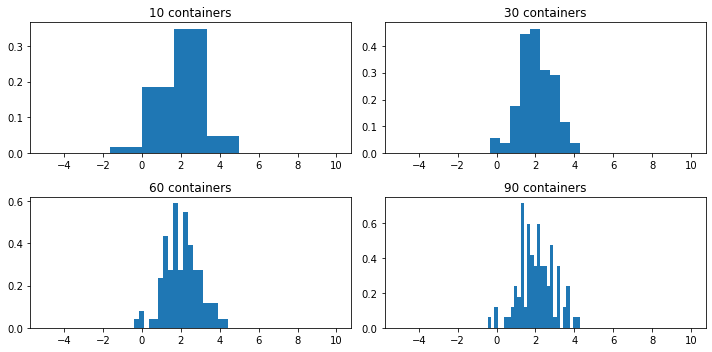

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

sample_containers = np.array([[10, 30], [60, 90]])

for i in range(2):
    for j in range(2):
        n_containers = sample_containers[i, j]
        axs[i, j].set_title(f"{n_containers} containers")
        plot_histogram(xs, (-5, 10), n_containers, axes=axs[i, j])

plt.tight_layout()
plt.show()

Para evitar este problema podemos utilizar **estimadores de densidad**:

Un *estimador de densidad* es una funcion que estima la densidad de cualquier valor respecto a la distribucion de nuestros puntos.

Podemos controlar la forma del estimador indicandole la forma de distribucion de nuestra variable (*kernel*):
- *gaussian*
- *tophat*
- *epanechnikov*
- *exponential*
- *linear*
- *cosine*

Y un parametro ***bandwidth*** que vale 1 por defecto.

De esta forma, podemos obtener graficos mucho mas suaves:

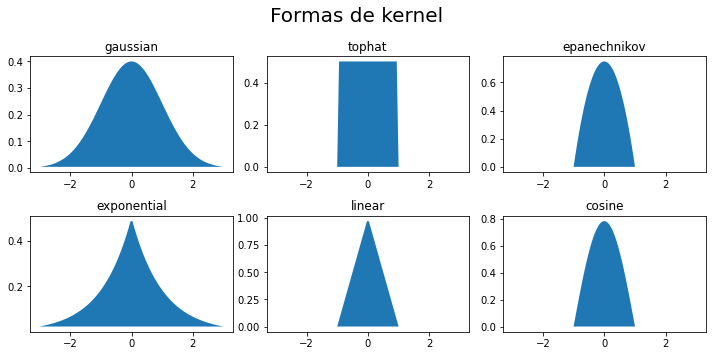

In [4]:
from sklearn.neighbors import KernelDensity

variable = np.zeros((1, 1))

domain = np.linspace(-3, 3, 100).reshape(-1, 1)
sample_kernels = np.array(['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear','cosine']).reshape(2, 3)

fig, axs = plt.subplots(2, 3, figsize=(10, 5))

for i in range(2):
    for j in range(3):
        kernel = sample_kernels[i, j]
        axs[i, j].set_title(kernel)
        d_estimator = KernelDensity(kernel=kernel).fit(variable)
        scores = d_estimator.score_samples(domain)
        axs[i, j].fill(domain, np.exp(scores))
        
fig.suptitle("Formas de kernel", fontsize=20)
plt.tight_layout()
plt.show()

- Es importante notar que `KernelDensity.score_samples()` retorna el `ln(densidad)` de cada punto
- Por esa razón, para utilizar los valores de densidad hacemos `np.exp(scores)`

Aplicando el estimador a al ejemplo:

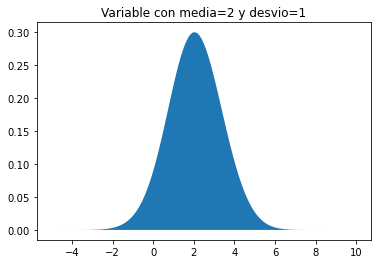

In [5]:
d_estimator = KernelDensity(kernel='gaussian').fit(xs)
domain = np.linspace(-5, 10, 1000).reshape(-1, 1)
scores = d_estimator.score_samples(domain)

plt.title("Variable con media=2 y desvio=1")
plt.fill(domain, np.exp(scores))
plt.show()

<br/>

## Modelos de redes neuronales

Una red neuronal es una representación simplificada de cómo piensan las neuronas en un cerebro humano.

Una neurona es como una función, toma varias entradas y calcula una salida. Las neuronas se conectan con otras, por lo tanto, la salida de una es una de las entradas de otra.

Podemos graficar un conjunto de neuronas y sus conexiones (red neuronal) a través de un grafo, donde cada nodo representa una neurona:

![Imagen grafo](https://scikit-learn.org/stable/_images/rbm_graph.png)

### Funcionamiento de la red

Una red neuronal se compone de varias capas, que podemos clasificar como: *de entrada*, *ocultas* y *de salida*.

La capa de *entrada* (1) está compuesta por todos los nodos en el primer nivel de la red, su salida se corresponderá con el input del sistema (el valor del punto que se quiere evaluar).

La capa de *salida* (1) esta compuesta por todos los nodos en el ultimo nivel del grafo, su salida se corresponderá con el output del sistema (el resultado, la predicción).

Las capas *ocultas* (N) son todas las capas entre la capa de entrada y de salida de la red.

![Red neuronal con descripcion de capas](https://miro.medium.com/max/700/0*hzIQ5Fs-g8iBpVWq.jpg)

##### Input
El input de cada neurona se calcula mediante la suma de todos outputs de las neuronas conectadas a ella de la capa anterior (los niveles de activación). Es decir, la activación de una neurona tiene un efecto sobre todas las demas con las que esté conectada de la siguiente capa.

Una neurona no afecta a todas sus conexiones por igual, puede afectar a una en menor o mayor medida que a otras. Por eso decimos que cada conexion entre neuronas tiene asociado un peso (**weight**) que indica con qué magnitud afecta una neurona a la otra.

Por otro lado, no todas las neuronas son igual de faciles de *activar*, por eso, cada neurona tiene asociado un **bias** que aumenta o disminuye la facilidad con la que se activa.

Por lo tanto, el input de una neurona *i* en la capa *c* estará dado por:

![equation](https://latex.codecogs.com/gif.latex?input_i^{(c)}&space;=&space;w_0&space;*&space;a_0^{(c-1)}&space;&plus;&space;w_1&space;*&space;a_1^{(c-1)}&space;&plus;&space;...&space;&plus;&space;w_n&space;*&space;a_n^{(c-1)}&space;&plus;&space;b_i^{(c)})
- La suma ponderada de las activaciones u outputs de las neuronas de la capa anterior + el *bias* de la propia neurona

##### Output
Cada neurona transforma el input recibido a un valor, generalmente dentro del intervalo (0, 1), que represente que tanto se activó respecto al input.

Para ello se utiliza una función que llamamos **\"funcion de activacion\"**. Como por ejemplo:

![Funcion image](https://saugatbhattarai.com.np/wp-content/uploads/2018/06/Reluvssigmoid.png)

- El *bias* de la neurona simula un desplazamiento en X de esta funcion, haciendo más o menos facil la activacion de la misma
- _**NOTA:** también se suelen utilizar funciones que retornan valores en el intervalo (0, +inf) como es el caso de la funcion <ins>ReLU</ins>._


Por lo tanto, la activación de la neurona *i* en la capa *c* puede calcularse como:

![Imagen de funcion output](https://latex.codecogs.com/gif.latex?output_i^{(c)}&space;=&space;\sigma(input_i^{(c)})&space;=&space;\sigma(w_0&space;*&space;a_0^{(c-1)}&space;&plus;&space;w_1&space;*&space;a_1^{(c-1)}&space;&plus;&space;...&space;&plus;&space;w_n&space;*&space;a_n^{(c-1)}&space;&plus;&space;b_i^{(c)}))

Donde:
- *sigma:* representa la **funcion de activacion**

Luego, puede generalizarse la obstención del vector de activaciones de todos los nodos de una capa *c* como:

![Imagen funcion activaciones](https://latex.codecogs.com/gif.latex?A^{(c)}&space;=&space;\sigma(Kernel^{(c)}&space;\cdot&space;A^{(c-1)}&space;&plus;&space;B^{(c)}))

Donde:
- Kernel: la matriz de "pesos" de la capa
    - Cada fila representa el vector de pesos de las conexiones con un nodo de la capa en cuestion
    - Kernel sera una matriz de dimensiones: `TamañoDeLaCapaEnCuestion x TamañoDeLaCapaAnterior`
- A: el vector de activaciones de una capa dada
- B: el vector de *biases* de cada nodo de la capa en cuestion

##### Conclusión:
- Las neuronas de entrada afectan a la primera capa oculta
- Luego todas las neuronas de las capas ocultas afectan a las de la capa siguiente hasta llegar a la capa de salida
- Finalmente, el vector de activaciones de la capa de salida corresponderá al output del sistema (el resultado, la prediccion)

### Entrenamiento
El entrenamiento de la red conciste en encontrar la mejor combinacion de valores para todos los **pesos** y **biases** de forma que se minimice el "costo" o "error" promedio respecto a un conjunto de entrenamiento.

- Partiendo de un vector de pesos y biases arbitrario, se obtiene el resultado de procesar cada input del conjunto de prueba
- Luego se calcula el error de cada input a partir de la diferencia entre su resultado y el valor "real" o "deseado"
- Finalmente se obtiene el error promedio entre todos los elementos del conjunto de entrenamiento
- Si el error promedio no es lo "suficientemente" chico, se modifican los valores de los pesos y biases utilizando el negativo del gradiente de la función de costo (la dirección en la que mas rapido disminuye) y se vuelve a repetir el proceso

Este algoritmo se conoce como **_gradient decent_**.

*Para mas información sobre el funcionamiento de las redes y del algoritmo de entrenamiento recomiendo esta playlist: [Neural Networks - 3Blue1Brown](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)*

<br/>

### Ejemplo 1: *sklearn*

Una forma de crear rapidamente un modelo de red neuronal es utilizando la clase `MLPClassifier` (Multi-Layer Perception Classifier) de `sklearn.neural_network`.

Para este ejemplo vamos a clasificar, nuevamente, el dataset `iris`:

In [6]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
data = iris.data
target = iris.target

train_data, test_data, train_target, test_target = train_test_split(data, target, train_size=0.9)  # 90% de entrenamiento

In [7]:
from sklearn.neural_network import MLPClassifier

neural_network = MLPClassifier(max_iter=2000, hidden_layer_sizes=(7, 7), activation='relu')
neural_network.fit(train_data, train_target)

score = neural_network.score(test_data, test_target)
print(f"Porcentaje de coincidencia: {round(score * 100, 2)}%")

Porcentaje de coincidencia: 100.0%


- Definimos una red con 2 capas ocultas de 7 neuronas cada una
- La capa de entrada tiene tantas neuronas como caracteristicas del input
- La capa de salida tiene tantas neuronas como clasificaciones posibles, dadas por el target

Para lograr la convergencia de la red, se puede modificar el parametro de `max_iter` que indica el numero maximo de iteraciones de "*gradient descent*" que llevará a cabo el algoritmo de entrenamiento.

Otra forma de lograrlo es aumentando el numero de capas ocultas o bien el numero de neuronas por capa modificando el parametro `hidden_layer_sizes` (una lista de la cantidad de neuronas que tendrá cada capa oculta).
- Este ultimo permite lograr la convergencia con un menor numero de iteraciones, pero aumenta la cantidad de *pesos* y *biases* para procesar
- Complejizar la red mediante este parametro tambien puede llevar a "_overfiting_" (sobreajuste), es decir, el modelo deja de generalizar, se entrena demaciado bien para el conjunto de entrenamiento y no arroja buenos resultados para inputs desconocidos (de prueba)
    - el algoritmo de aprendizaje puede quedar ajustado a unas características muy específicas de los datos de entrenamiento que no tienen relación causal con la función objetivo

<br/>

### Ejemplo 2: *TensorFlow*
En este ejemplo entrenaremos un modelo de red neuronal para clasificar imágenes de ropa. Para ello vamos a utilizar el dataset MNIST, que contiene 70.000 imágenes en escala de grises de 10 categorias de ropa diferentes.

Las imagenes muestran articulos individuales de ropa con una resolución de 28x28 pixeles.

En este ejemplo vamos a usar la API de `Keras` de TensorFlow para desarrollar el modelo. Esta API nos permite crear modelos de redes neuronales facilmente utilizando a las capas de la red como los bloques de construcción basicos. Esto nos permite tener un mayor control sobre el funcionamiento de cada capa y aprobechar la velocidad de el codigo en C++ que utiliza TensorFlow.

In [8]:
import tensorflow as tf
from tensorflow import keras

##### 1) Importamos el conjunto de datos a utilizar:

In [9]:
fashion_mnist = keras.datasets.fashion_mnist

(train_data, train_target), (test_data, test_target) = fashion_mnist.load_data()
print(f"Train data samples: {len(train_data)}")
print(f"Test data samples: {len(test_data)}")
print(f"Data shape: {train_data[0].shape}")

Train data samples: 60000
Test data samples: 10000
Data shape: (28, 28)


Los datos tiene 10 clasificaciones posibles, de 0 a 9, donde el nombre de cada clasificacion esta dado por:

In [10]:
labels = ["T-shirt/Top", 
          "Trouser", 
          "Pullover", 
          "Dress", 
          "Coat", 
          "Sandal", 
          "Shirt", 
          "Sneaker", 
          "Bag",
          "Ankle boot"]

##### 2) Escalamos los valores de entrada a un rango entre 0 y 1 dividiendolos por 255 (el valor maximo)

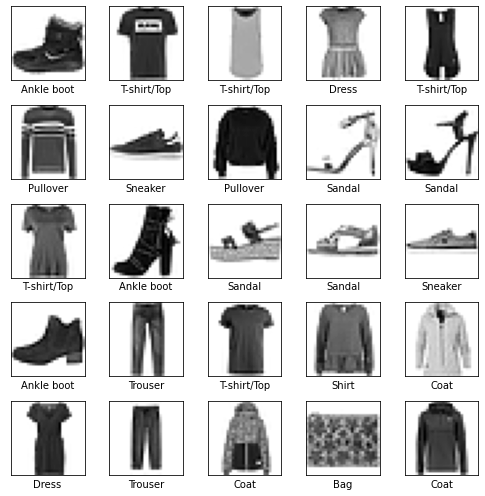

In [11]:
scaled_train_data = train_data / 255
scaled_test_data = test_data / 255

fig, axs = plt.subplots(5, 5, figsize=(7, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_data[i], cmap=plt.cm.binary)
    plt.xlabel(labels[train_target[i]])

plt.tight_layout()
plt.show()

##### 3) Construimos el modelo:

Los bloques basicos para la consstruccion de una red son las capas. En particular las capas ocultas y la de salida ya que la de entrada esta dada por las dimensiones de los datos.

El modulo `keras.layers` define una gran variedad de tipos de capas configurables. Cada tipo tiene sus propias caracteristicas y funcionalidades especificas.

Para este ejemplo vamos a utilizar 2 tipos de capas:
- `Dense`: es una capa que esta completamente conectada con la capa anterior, es decir, todos sus nodos tienen conexiones a todos los nodos de la capa anterior
- `Flatten`: es una capa que convierte un input de varias dimensiones a uno de 1
    - El numero de neuronas de esta capa estará dado por el numero total de valores de la matriz input original
    - Ej: si el input es una matriz de 28x28 el numero de nodos de esta capa será 784, y por lo tanto, la salida de la capa será un vector de 784 valores (1 dimensión)
    
    
La clase `keras.Sequential` nos permite combinar nuestras capas para asi construir el modelo.

In [12]:
neural_network = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # 1ra capa oculta
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)  # Capa de salida
])

Podemos utilizar el metodo `summary` para entender mejor como está compuesto nuestro modelo:

In [13]:
neural_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


- La capa de entrada tiene como salida una matriz de 28x28 (una imagen)
- La primera capa oculta, de tipo `Flatten`, esta compuesta por 784 (28x28) neuronas, entonces su salida será un vector de tamaño 784
    - Esta capa no incorpora nuevos parametros (pesos y biases) ya que su función no es reaccionar al input, sino, transformarlo
- La segunda capa oculta es de tipo `Dense`, está compuesta por 128 neuronas (valor arbitrario que se indicó) y, por lo tanto, su salida será un vector de tamaño 128
    - Al ser una capa de tipo "dense", la cantidad de parametros que agrega al modelo sera igual a uno por cada conexion con la capa anterior (todas las posibles) más un bias por cada nodo:\
    `784 x 128 + 128 = 100480`
- La capa de salida, también de tipo `Dense`, esta compuesta por 10 neuronas, resultando en un vector de salida de tamaño 10 igual al numero de caracteristicas posibles
    - Agregando `128 x 10 + 10 = 1290` parametros más
    - A diferencia de la capa anterior, esta utiliza la funcion de activacion _"softmax"_ que produce una salida cuya suma total es igual a 1, por lo tanto, el valor asociado a cada posicion del vector de salida será la probabilidad o certeza que tiene el modelo de que esa posicion representa la clasificacion correcta

##### 4) Antes de entrenar el modelo debemos compilarlo, indicandole:
- La *funcion de perdida* (costo / error) a utilizar (Ej: error cuadratico medio)
- El *algorimo de optimizacion* (Ej: descenso de gradiente)
- Y las metricas que queremos visualizar durante el entrenamiento del mismo

Los valores posibles para estos tres atributos los podemos ver en la documentacion:
- [Perdidas](https://keras.io/api/losses/)
- [Optimizadores](https://keras.io/api/optimizers/)
- [Metricas](https://keras.io/api/metrics/)

Para nuestro ejemplo vamos a utilizar:
- "sparse_categorical_crossentropy" como funcion de perdida
- "adam" como optimizador
- "accuracy" como unica métrica para visualizar

In [14]:
neural_network.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

##### 5) Entrenamos el modelo:

In [15]:
_ = neural_network.fit(scaled_train_data, train_target, epochs=5, verbose=2)

Epoch 1/5
1875/1875 - 2s - loss: 0.4952 - accuracy: 0.8282
Epoch 2/5
1875/1875 - 1s - loss: 0.3748 - accuracy: 0.8643
Epoch 3/5
1875/1875 - 1s - loss: 0.3375 - accuracy: 0.8767
Epoch 4/5
1875/1875 - 1s - loss: 0.3143 - accuracy: 0.8853
Epoch 5/5
1875/1875 - 1s - loss: 0.2964 - accuracy: 0.8906


- Con el parametro `epochs` le indicamos al modelo cuantas veces volver a entrenar con los mismos datos
    - Es decir, cuantas veces procesar el dataset entero
    - Esto generalmente mejora la prediccion. Podemos ver que con cada *epoch* aumenta el valor de `accuracy`
- El parametro `verbose` sirve para indicar el nivel con el que queremos que se describa el proceso de entrenamiento, con un nivel de 2 logramos el texto que aparece arriba

##### 5) Probamos el modelo con el conjunto de prueba: 

In [16]:
loss, accuracy = neural_network.evaluate(scaled_test_data, test_target)
print(f"Porcentaje de aciertos: {accuracy * 100} %")

313/313 [==============================] - 0s 744us/step - loss: 0.3772 - accuracy: 0.8666
Porcentaje de aciertos: 86.6599977016449 %


- Algo para tener en cuenta en esta instancia es que si, por ejemplo, el porcentaje de aciertos obtenido con el conjunto de entrenamiento es muchisimo mayor al obtenido con el de prueba, entonces nuestro modelo está **sobreajustado** y, por lo tanto, habria que hacer modificaciones a su diseño

##### 6) Finalmente podemos visualizar como el modelo clasifica algunos ejemplos:

In [17]:
predictions = neural_network.predict(scaled_test_data)
predictions.shape

(10000, 10)

- Recordemos que para cada imagen el modelo responderá con un vector que indica con qué certeza cree que esta se clasifica con cada clasificacion posible

Tomando como ejemplo la imagen 544, una imagen que se ve bastante dificil de clasificar por su calidad y colores muy claros, el modelo responde con:

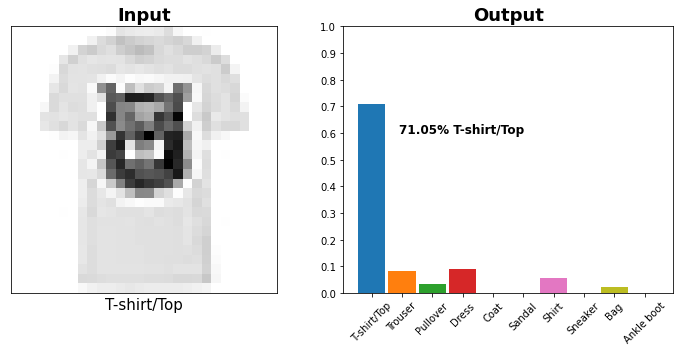

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

IMG_INDEX = 544

axs[0].set_title("Input", fontweight="bold", fontsize=18)
axs[0].set_xticks([])
axs[0].set_yticks([])
real_classification = labels[test_target[IMG_INDEX]]
axs[0].set_xlabel(real_classification, fontsize=15)
axs[0].imshow(scaled_test_data[IMG_INDEX], cmap=plt.cm.binary)

img_prediction = predictions[IMG_INDEX]

width = 1
xticks = np.linspace(0, 10, len(labels))
for c in range(10):
    axs[1].bar(xticks[c], img_prediction[c], width)

axs[1].set_xticks(xticks)
axs[1].set_xticklabels(labels, rotation=45)
axs[1].set_yticks(np.arange(0, 1.1, step=0.1))
axs[1].set_title("Output", fontweight="bold", fontsize=18)

best_index = np.argmax(img_prediction)  # Indice del maximo valo en el vector
classification = labels[best_index]
certainty = round(np.max(img_prediction) * 100, 2)
plt.text(1, 0.6, f"{certainty}% {classification}", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()